In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
data = pd.read_csv('financial_anomaly_data.csv')

In [8]:
data.dropna(subset=['Timestamp', 'TransactionID', 'AccountID', 'Amount', 'Merchant', 'TransactionType', 'Location'], inplace=True)

In [10]:
# Convert Timestamp to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d-%m-%Y %H:%M')

# Extract additional features from Timestamp
data['Date'] = data['Timestamp'].dt.date
data['Hour'] = data['Timestamp'].dt.hour

# Check the cleaned data
print(data.head())

            Timestamp TransactionID AccountID    Amount   Merchant  \
0 2023-01-01 08:00:00       TXN1127      ACC4  95071.92  MerchantH   
1 2023-01-01 08:01:00       TXN1639     ACC10  15607.89  MerchantH   
2 2023-01-01 08:02:00        TXN872      ACC8  65092.34  MerchantE   
3 2023-01-01 08:03:00       TXN1438      ACC6     87.87  MerchantE   
4 2023-01-01 08:04:00       TXN1338      ACC6    716.56  MerchantI   

  TransactionType     Location        Date  Hour  
0        Purchase        Tokyo  2023-01-01     8  
1        Purchase       London  2023-01-01     8  
2      Withdrawal       London  2023-01-01     8  
3        Purchase       London  2023-01-01     8  
4        Purchase  Los Angeles  2023-01-01     8  


count    216960.000000
mean      50090.025108
std       29097.905016
min          10.510000
25%       25061.242500
50%       50183.980000
75%       75080.460000
max      978942.260000
Name: Amount, dtype: float64


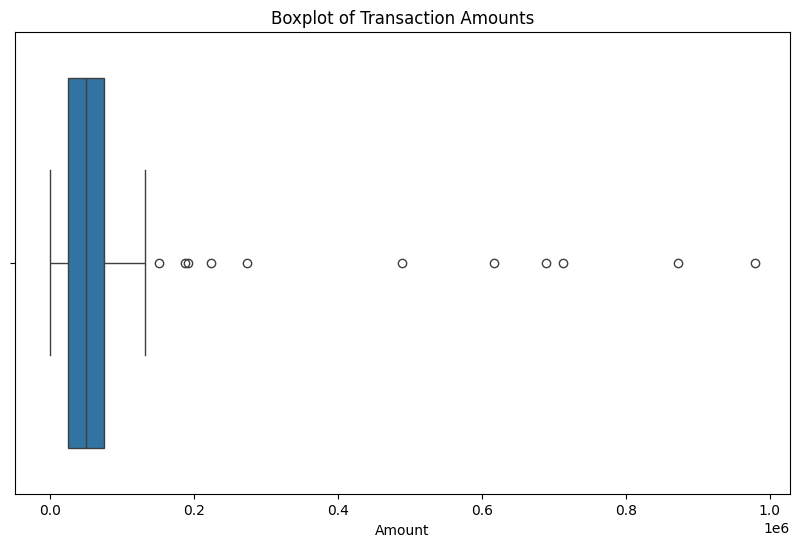

In [11]:
# Summary statistics for Amount
print(data['Amount'].describe())

# Box plot for Amount
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['Amount'])
plt.title('Boxplot of Transaction Amounts')
plt.show()


In [12]:
# Calculate Z-score for Amount
data['Amount_Zscore'] = np.abs(stats.zscore(data['Amount']))

# Set threshold for anomaly detection (e.g., Z-score > 3)
zscore_threshold = 3
anomalies_zscore = data[data['Amount_Zscore'] > zscore_threshold]

# Display flagged anomalies
print("Flagged Anomalies based on Z-score:")
print(anomalies_zscore[['TransactionID', 'AccountID', 'Amount', 'Merchant', 'TransactionType', 'Location']])


Flagged Anomalies based on Z-score:
       TransactionID AccountID     Amount   Merchant TransactionType  \
2775         TXN1049     ACC14  978942.26  MerchantJ        Transfer   
3448          TXN827     ACC12  712076.97  MerchantA      Withdrawal   
3453         TXN1690      ACC8  489492.30  MerchantF        Purchase   
4148          TXN625      ACC1  187344.37  MerchantD        Purchase   
4194          TXN667      ACC3  272990.11  MerchantE        Transfer   
45099        TXN1359     ACC11  151020.55  MerchantB        Transfer   
45100         TXN190      ACC5  873004.79  MerchantI      Withdrawal   
211753        TXN141      ACC4  223542.64  MerchantG      Withdrawal   
211866        TXN543      ACC2  191561.95  MerchantJ        Purchase   
211959       TXN1359      ACC8  616155.70  MerchantC        Purchase   
213460       TXN1249      ACC5  689504.90  MerchantI        Purchase   

             Location  
2775         New York  
3448            Tokyo  
3453            Tokyo  
414

In [13]:
# Prepare data for Isolation Forest
features = ['Amount', 'Hour']
X = data[features]

# Fit Isolation Forest model
clf = IsolationForest(random_state=0, contamination=0.05)  # 5% expected anomalies
clf.fit(X)

# Predict outliers
data['Anomaly_Score'] = clf.decision_function(X)
data['Anomaly_Label'] = clf.predict(X)

# Flag transactions flagged as anomalies by Isolation Forest
anomalies_if = data[data['Anomaly_Label'] == -1]

# Display flagged anomalies
print("Flagged Anomalies based on Isolation Forest:")
print(anomalies_if[['TransactionID', 'AccountID', 'Amount', 'Merchant', 'TransactionType', 'Location']])


Flagged Anomalies based on Isolation Forest:
       TransactionID AccountID    Amount   Merchant TransactionType  \
3            TXN1438      ACC6     87.87  MerchantE        Purchase   
4            TXN1338      ACC6    716.56  MerchantI        Purchase   
7             TXN841      ACC7   1336.36  MerchantI      Withdrawal   
16            TXN648      ACC8   1417.84  MerchantC        Purchase   
142           TXN831     ACC13    269.48  MerchantD        Purchase   
...              ...       ...       ...        ...             ...   
216943       TXN1915      ACC1  15239.39  MerchantE        Purchase   
216944        TXN652     ACC12   4150.21  MerchantF        Transfer   
216945        TXN284     ACC14  93965.35  MerchantE      Withdrawal   
216949       TXN1182     ACC10   9657.19  MerchantE        Purchase   
216957       TXN1979     ACC15   8203.57  MerchantF        Purchase   

             Location  
3              London  
4         Los Angeles  
7       San Francisco  
16    